# Training Convolutional Nets

In this exercise we will look more into ConvNets

As discussed in the lecture, the key ideas to convnets are local connectivity and weight sharing which lead us to convolutions.

Before trying to *learn* convolutional filters, let's manually construct them

## Step 1 - Image Processing

Write a function that downloads an image at a given URL and converts it into greyscale and returns a 2D array.

Tip: use the `requests` and the `PIL` python libraries

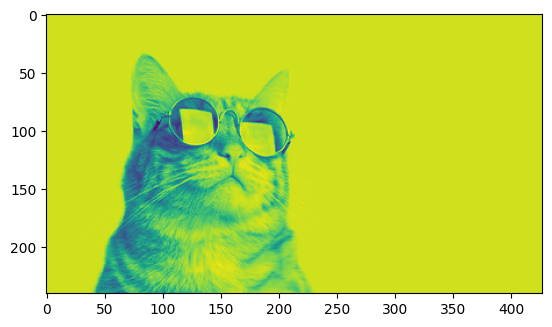

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import requests
from PIL import Image, ImageOps
from io import BytesIO

def download_and_grayscale(url):
    r = requests.get(url)
    b = r.content

    image = Image.open(BytesIO(b))
    grey = ImageOps.grayscale(image)
    return np.array(grey)

image = download_and_grayscale('https://t4.ftcdn.net/jpg/03/03/62/45/240_F_303624505_u0bFT1Rnoj8CMUSs8wMCwoKlnWlh5Jiq.jpg')
plt.imshow(image)

## Step 2 - the `torch.nn.Conv2D` object

Research how to access the parameters of the convolution kernel module `torch.nn.Conv2D` in PyTorch and make sure you understand where 
kernel size, input channels and output channels come into definint the shape of the parameter tensors.


## Step 3 - Manually creating Convolutions

Create a `Conv2D` module with 1 input channel and 2 output channels with kernel size 3

* set the weights of of first output channel is a vertical edge detector
* set the weights of the second output channel is a horizontal edge detector
* create a size 1 input batch with a greyscale image of your choice and visualize the outputss

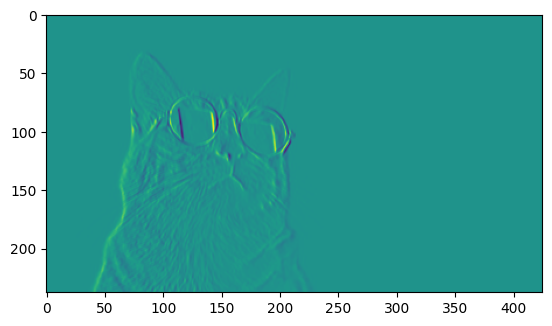

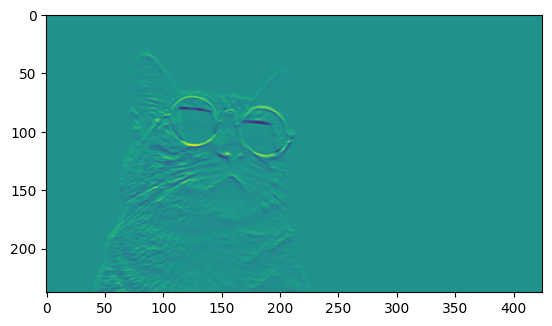

In [2]:
import torch
conv = torch.nn.Conv2d(1,2,3, bias=False)
conv.weight.data[0,0,:,:] = torch.tensor([[1,0,-1],[1,0,-1],[1,0,-1]])
conv.weight.data[1,0,:,:] = torch.tensor([[1,1,1],[0,0,0],[-1,-1,-1]])

out = conv(torch.tensor(image).unsqueeze(0).unsqueeze(0).float())
plt.imshow(out.detach()[0,0])
plt.show()
plt.imshow(out.detach()[0,1])

## Step 4 - Make a CNN

Create a ConvNet with the following structure

* Conv 5 x 5 ( 1 -> 16 channels) -> ReLU -> MaxPool 2 x 2
* Conv 3 x 3 ( 16 -> 16 channels) -> ReLU -> MaxPool 2 x 2
* Conv 2 x 2 ( 16 -> 32 channels)

Find out what the output on a random MNIST-like torch tensor is, i.e. `x = torch.randn(123,1,28,28)`

In [19]:
model = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(2),
    torch.nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(2),
    torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=2),
)
model(torch.randn(123,1,28,28)).shape

torch.Size([123, 32, 4, 4])

* Use `torch.nn.Unflatten` to make the model work with "flattened" MNIST tensors as we had them in the prior exercise, i.e. the model 
should work with a tensor `x = torch.randn(123,784)`
* Use `torch.nn.Flatten` to flatten all the remaining dimensions after the three convolutions into

How big is this intermediate representation of an image?

In [20]:
model = torch.nn.Sequential(
    torch.nn.Unflatten(-1,(1,28,28)),
    torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(2),
    torch.nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(2),
    torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=2),
    torch.nn.Flatten()
)
model(torch.randn(123,784)).shape

torch.Size([123, 512])

## Step 5 - Train a CNN on MNIST

* Take a note of the number of outputs after `Flatten` and add a final lineary projection layer (i.e. a perceptron) to the network to 
predict 10 logits
* Adapt your solution from Exercise 6 to train a CNN on mnist images

In [27]:
def create_cnn():
    return torch.nn.Sequential(
        torch.nn.Unflatten(-1,(1,28,28)),
        torch.nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(2),
        torch.nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(2),
        torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=2),
        torch.nn.Flatten(),
        torch.nn.Linear(512,10),
)

model = create_cnn()
print(model(torch.randn(123,28*28)).shape)

torch.Size([123, 10])


In [24]:
import mnist
train_labels = mnist.train_labels()
test_labels = mnist.test_labels()
scale_mean, scale_std = mnist.train_images().mean(),mnist.train_images().std()
train_images = (mnist.train_images()-scale_mean)/scale_std
test_images = (mnist.test_images()-scale_mean)/scale_std

def make_batch(N = 300, collection = 'train'):
    images = train_images if collection == 'train' else test_images
    labels = train_labels if collection == 'train' else test_labels
        
    indices = np.random.choice(np.arange(len(images)), size = (N,), replace = True)
    X = images[indices]
    y = labels[indices]
    return torch.FloatTensor(X.reshape(-1,28*28)),torch.LongTensor(y)

X, y = make_batch(N=300);
X.shape, y.shape

(torch.Size([300, 784]), torch.Size([300]))

In [25]:
def eval_model(model, collection):
    X,y = make_batch(N = 200, collection=collection)
    p = model(X)
    loss = torch.nn.functional.cross_entropy(p,y)
    return loss

def train(model_fn, Nsteps = 200):
    trajectory = []
    model = model_fn()
    optim = torch.optim.Adam(model.parameters(),1e-3)
    for i in range(Nsteps):
        
        loss = eval_model(model,'train')
        loss.backward()
        optim.step()
        optim.zero_grad()
        
        with torch.no_grad():
            loss_val = eval_model(model,'test')
        trajectory.append([float(loss),float(loss_val)])
        if i % 100 == 0:
            print(f'loss: {i}: {loss:.4f}')
    return model,np.array(trajectory)

In [26]:
trained_cnn,traj_cnn = train(create_cnn, Nsteps = 1001)

loss: 0: 2.3020
loss: 100: 0.1914
loss: 200: 0.1100
loss: 300: 0.1000
loss: 400: 0.1184
loss: 500: 0.1329
loss: 600: 0.0472
loss: 700: 0.1189
loss: 800: 0.0511
loss: 900: 0.0486
loss: 1000: 0.0428


## (Bonus: Let's compare to a MLP)

In [28]:
def create_mlp():
    return torch.nn.Sequential(
        torch.nn.Linear(784,200),
        torch.nn.ReLU(),
        torch.nn.Linear(200,200),
        torch.nn.ReLU(),
        torch.nn.Linear(200,200),
        torch.nn.ReLU(),
        torch.nn.Linear(200,10),
)

trained_mlp,traj_mlp = train(create_mlp, Nsteps = 1001)

loss: 0: 2.3063
loss: 100: 0.3054
loss: 200: 0.1924
loss: 300: 0.1796
loss: 400: 0.0696
loss: 500: 0.0638
loss: 600: 0.1119
loss: 700: 0.0474
loss: 800: 0.0615
loss: 900: 0.0442
loss: 1000: 0.1120


In [29]:
def count_params(model):
    return sum([p.numel() for p in model.parameters()])

n_cnn = count_params(trained_cnn)
n_mlp = count_params(trained_mlp)

We can plot the training and test set performance

[]

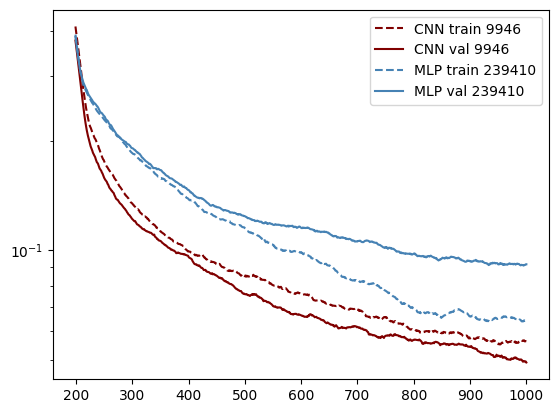

In [33]:
import pandas as pd

plt.plot(pd.DataFrame(traj_cnn[:,0]).rolling(200).mean(),label = f'CNN train {n_cnn}', c = 'maroon', linestyle = 'dashed')
plt.plot(pd.DataFrame(traj_cnn[:,1]).rolling(200).mean(),label = f'CNN val {n_cnn}', c = 'maroon', linestyle = 'solid')

plt.plot(pd.DataFrame(traj_mlp[:,0]).rolling(200).mean(),label = f'MLP train {n_mlp}', c = 'steelblue', linestyle = 'dashed')
plt.plot(pd.DataFrame(traj_mlp[:,1]).rolling(200).mean(),label = f'MLP val {n_mlp}', c = 'steelblue', linestyle = 'solid')
plt.legend()

plt.semilogy()

In [36]:
import torch
model = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True)
model.eval();

Using cache found in /Users/lukasheinrich/.cache/torch/hub/pytorch_vision_v0.10.0


In [38]:
from PIL import Image
from torchvision import transforms
def download_image(url):
    r = requests.get(url)
    b = r.content

    image = Image.open(BytesIO(b))
    return image

input_image = download_image('https://t4.ftcdn.net/jpg/03/03/62/45/240_F_303624505_u0bFT1Rnoj8CMUSs8wMCwoKlnWlh5Jiq.jpg')
preprocess = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

In [42]:
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

--2023-02-01 22:27:32--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8001::154, 2606:50c0:8002::154, 2606:50c0:8003::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8001::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt.2’

imagenet_classes.tx 100%[===================>]  10,23K  --.-KB/s    in 0,001s  

2023-02-01 22:27:33 (19,2 MB/s) - ‘imagenet_classes.txt.2’ saved [10472/10472]



In [43]:
with torch.no_grad():
    output = model(input_batch)

probabilities = torch.nn.functional.softmax(output[0], dim=0)
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

top5_prob, top5_catid = torch.topk(probabilities, 5)
for i in range(top5_prob.size(0)):
    print(categories[top5_catid[i]], top5_prob[i].item())


sunglasses 0.2775413393974304
tabby 0.2124539166688919
tiger cat 0.11657339334487915
sunglass 0.10845321416854858
Egyptian cat 0.04757053777575493


In [44]:
!open .